# Assignment 2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pprint

In [2]:
df_train=pd.read_csv("../data/train.csv")

In [3]:
# Data pipeline for training data
df_train=df_train.replace(to_replace="male",value=1)
df_train=df_train.replace(to_replace="female",value=0)
# These are the outliers there fare is very low but most of them are still saved thus they reduce the performance
df_train=df_train[df_train["Fare"]!=0]
df_train=df_train.fillna(df_train.median(skipna=True))
# Age doesn't seem logically right to be 0
df_train[df_train["Age"]<1]=1
df_train=df_train.reset_index()
df_train=df_train.drop(["index","PassengerId"],axis=1)

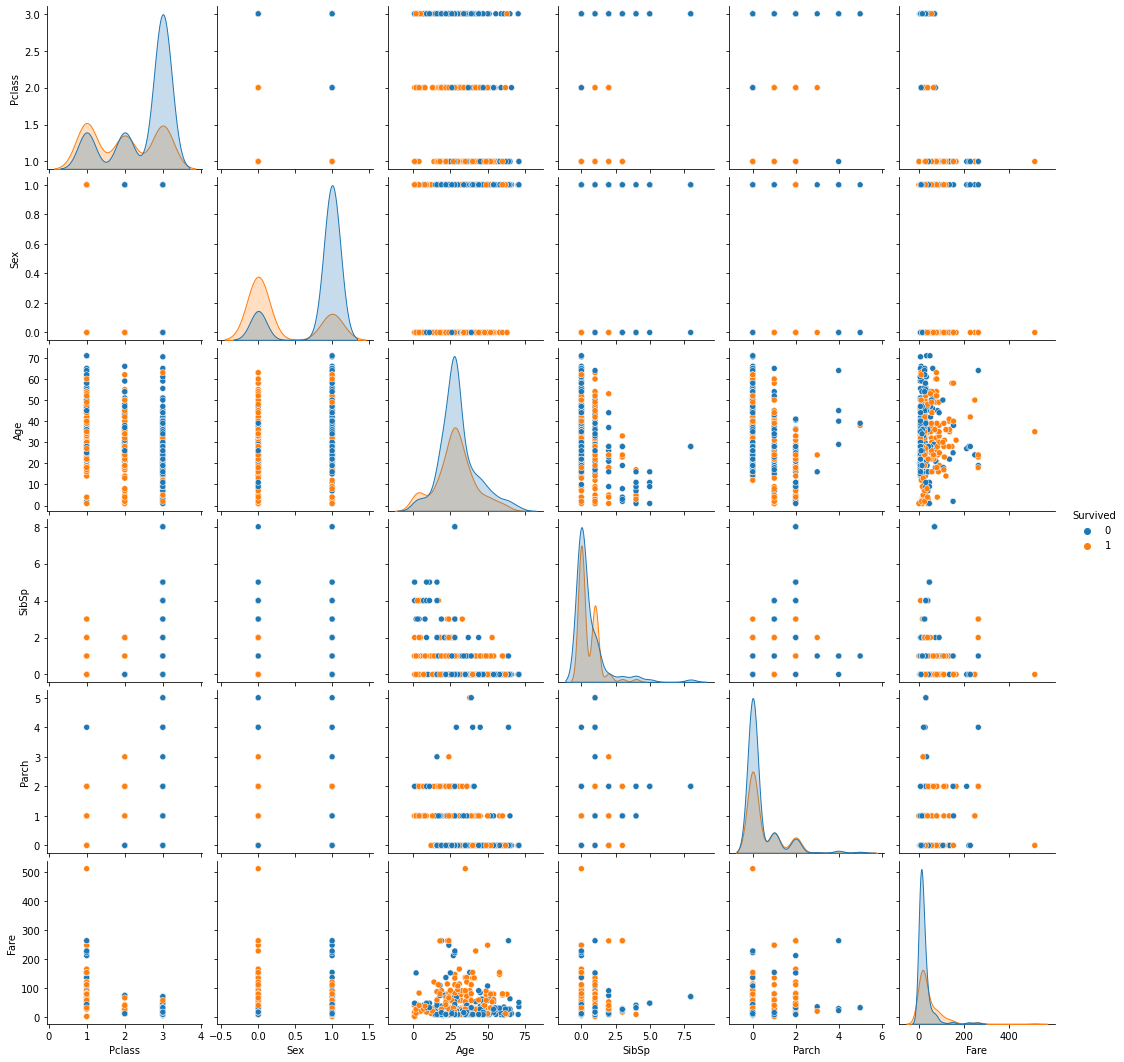

In [4]:
#Data visualisation
sns.pairplot(df_train,hue="Survived")

In [5]:
minSize=5          #min size of leaf
maxDepth=7          #max depth of tree
criterias=np.array(df_train.columns)
criterias=criterias[1:]     #removal of survived criteria
tree={}
balanceFactor=0.9   #balancing factor for tree

In [6]:
#using gini index
def getStump(df,prev):
    minCriteria="Age"
    minGini=np.inf
    minThreshold=0
    for i in criterias:
        if(prev == i):
            continue
        threshold=np.mean(df[i])
        s1=df[df[i]<threshold].shape[0]/df.shape[0]
        s2=df[df[i]>=threshold].shape[0]/df.shape[0]
        gini=1-s1**2-s2**2
        if(min(s1,s1)==0):
            continue
        gini=gini+balanceFactor*(max(s1,s2)/min(s1,s2)-1)
        if(gini<minGini):
            minGini=gini
            minCriteria=i
            minThreshold=threshold
    return minCriteria,minThreshold

In [7]:
def trainModel(df,node,depth,prev):
    criteria,threshold=getStump(df,prev)
    node["criteria"]=criteria;
    node["threshold"]=threshold
    node["isLeaf"]=0
    node["l"]={}
    node["r"]={}
    if(np.unique(df["Survived"]).shape==1):
        node["isLeaf"]=1
        if(df["Survived"].mean()<0.5):
            node["value"]=0
        else:
            node["value"]=1
        return node
    if(depth==maxDepth):
        node["isLeaf"]=1
        if(df["Survived"].mean()<0.5):
            node["value"]=0
        else:
            node["value"]=1
        return node
    if(df[df[criteria]<threshold].shape[0]<=minSize):
        if(df[df[criteria]<threshold]["Survived"].mean()<0.5):
            node["l"]["value"]=0
        else:
            node["l"]["value"]=1
        node["l"]["isLeaf"]=1
    else:
        node["l"]=trainModel(df[df[criteria]<threshold],node["l"],depth+1,criteria)
    if(df[df[criteria]>=threshold].shape[0]<=minSize):
        if(df[df[criteria]>=threshold]["Survived"].mean()<0.5):
            node["r"]["value"]=0
        else:
            node["r"]["value"]=1
        node["r"]["isLeaf"]=1
    else:
        node["r"]=trainModel(df[df[criteria]>=threshold],node["r"],depth+1,criteria)
    
    return node
    

In [8]:
tree=trainModel(df_train,tree,0,"")

In [9]:
#Tree formed
pprint.pprint(tree)

                      'l': {'criteria': 'Age',
                                           'isLeaf': 1,
                                           'l': {},
                                           'r': {},
                                           'threshold': 21.3,
                                           'value': 0},
                                     'r': {'isLeaf': 1, 'value': 0},
                                     'threshold': 22.295483333333333},
                               'r': {'criteria': 'Fare',
                                     'isLeaf': 0,
                                     'l': {'criteria': 'Age',
                                           'isLeaf': 1,
                                           'l': {},
                                           'r': {},
                                           'threshold': 28.9,
                                           'value': 0},
                                     'r': {'isLeaf': 1, 'value': 0},
                   

In [10]:
# Data pipeline for test data
df_test=pd.read_csv("../data/test.csv")
df_test=df_test.replace(to_replace="male",value=1)
df_test=df_test.replace(to_replace="female",value=0)
df_test=df_test.fillna(df_test.median(skipna=True))
df_test=df_test.reset_index()

In [11]:
yPredTest=np.array([])
for i in df_test.index:
    node=tree
    while(node["isLeaf"]==0):
        if(df_test.iloc[i][node["criteria"]]<node["threshold"]):
            node=node["l"]
        else:
            node=node["r"]
    yPredTest=np.append(yPredTest,[node["value"]])

yPredTrain=np.array([])
for i in df_train.index:
    node=tree
    while(node["isLeaf"]==0):
        if(df_train.iloc[i][node["criteria"]]<node["threshold"]):
            node=node["l"]
        else:
            node=node["r"]
    yPredTrain=np.append(yPredTrain,[node["value"]])

In [12]:
def stats(yPred,yTrue):
    loss=0
    fn=0
    tp=0
    fp=0
    tn=0
    for i in range(len(yPred)):
        loss=loss+(yPred[i]-yTrue[i])**2
        if yPred[i]==0 and yTrue[i]==1:
            fn +=1
        elif yPred[i]==1 and yTrue[i]==1:
            tp +=1
        elif yPred[i]==1 and yTrue[i]==0:
            fp +=1
        else:
            tn +=1

    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    accuracy=(tp+tn)/(len(yPred))
    f1_score=2/(1/precision+1/recall)

    return accuracy,loss,f1_score

In [13]:
accuracy,loss,f1_score=stats(yPredTrain,df_train["Survived"])
print("Stats for training data")
print("Accuracy= ",accuracy)
print("Loss= ",loss)
print("F1 score= ",f1_score,"\n")
accuracy,loss,f1_score=stats(yPredTest,df_test["Survived"])
print("Stats for testing data")
print("Accuracy= ",accuracy)
print("Loss= ",loss)
print("F1 score= ",f1_score)

Stats for training data
Accuracy=  0.8576104746317512
Loss=  87.0
F1 score=  0.8213552361396306 

Stats for testing data
Accuracy=  0.8044280442804428
Loss=  53.0
F1 score=  0.7309644670050762
